<font size="8">Evaluation of single cell detectors</font> 

Evaluation is done based on:
- Evaluation dataset
- Different confluencys
- Generalization on new cell lines

____

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import cv2

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Own scripts
from data import tf_record_loading, bbox_utils
from prediction import simple_confluency, prediction_utils
from statistics import get_performance_metrics

In [2]:
# Set default figure size
matplotlib.rcParams['figure.figsize'] = (12, 6)

____

**HELPER FUNCTIONS**

In [3]:
def evaluate_on_series(model, data, iou=0.5):
    """
    Get evaluation metrics on all images in data
    
    :param model: tf_model
    :param data: list/generator of dict with keys: ["name(s)", "image(s)", "bboxes"]
    :return: list of dict with metrics
    """
    metrics = []

    for query in data:
        image = query.get("image")
        gt_boxes = query.get("bboxes")

        pred_boxes = prediction_utils.run_inference_for_single_image(model, image)
        pred_boxes = pred_boxes.get("detection_boxes")
        metrics.append(get_performance_metrics(pred_boxes, gt_boxes, iou=iou))
    
    return metrics

**<font size="6">  Setup model and data path </font>**

In [44]:
# Model should be exported tensorflow model. (Must contain: saved_model subfolder, model.ckpt, frozen_inference_graph)
BF_MODEL_PATH = Path(r"D:\Nabil_object_detection\models\graph_imgSize_vs_bboxSize\ssd_resnet50_v1_fpn_10x_tiles0_bboxes40")
LF_MODEL_PATH = Path(r"D:\Nabil_object_detection\models\graph_imgSize_vs_bboxSize\ssd_resnet50_v1_fpn_z00_tiles0_bboxes40")

# TF Records as generated by data.tf_record_writer. data.tf_dataset_generator(laod_tf_dataset) will produce keys: ["name(s)", "image(s)", "bboxes"]
LF_VAL_DATA_PATH = Path(r"D:\Nabil_object_detection\val\z00_tiles0_bboxes40.tfrecord")
BF_VAL_DATA_PATH = Path(r"D:\Nabil_object_detection\val\10x_tiles0_bboxes40.tfrecord")

# Perfomance on validation data

In [5]:
val_data_generator = tf_record_loading.tf_dataset_generator(LF_VAL_DATA_PATH)
model = prediction_utils.load_model(LF_MODEL_PATH)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [6]:
metrics = evaluate_on_series(model, val_data_generator)

In [23]:
# Show all measured metrics. For defeinition see: https://en.wikipedia.org/wiki/Receiver_operating_characteristic

print(metrics[0].keys())

aucs = [i.get("auc") for i in metrics]
fdrs = [i.get("fdr") for i in metrics]
fnrs = [i.get("fnr") for i in metrics]

dict_keys(['tp', 'fn', 'fp', 'recall', 'precision', 'recalls', 'precisions', 'fnr', 'fdr', 'map', 'auc'])


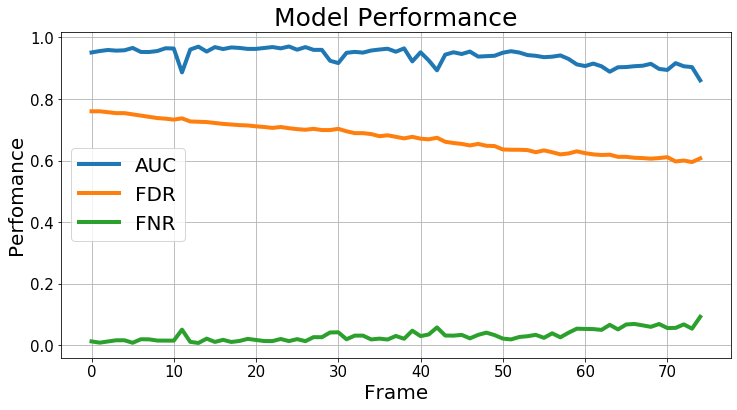

In [56]:
frames = list(range(len(aucs)))
sns.lineplot(frames, aucs, lw=4, label="AUC")
sns.lineplot(frames, fdrs, lw=4, label="FDR")
sns.lineplot(frames, fnrs, lw=4, label="FNR")
plt.title("Model Performance", fontsize=25)
plt.xlabel("Frame", fontsize=20)
plt.ylabel("Perfomance", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=20)
plt.grid()

# Evaluation on different confluencys

In [45]:
# Reload data generator. Must be brightfield, because confluency detection is based on simple filters.
val_data_generator = tf_record_loading.tf_dataset_generator(BF_VAL_DATA_PATH)

In [46]:
confluencys = [simple_confluency.get_image_confluency(x.get("image")) for x in val_data_generator]

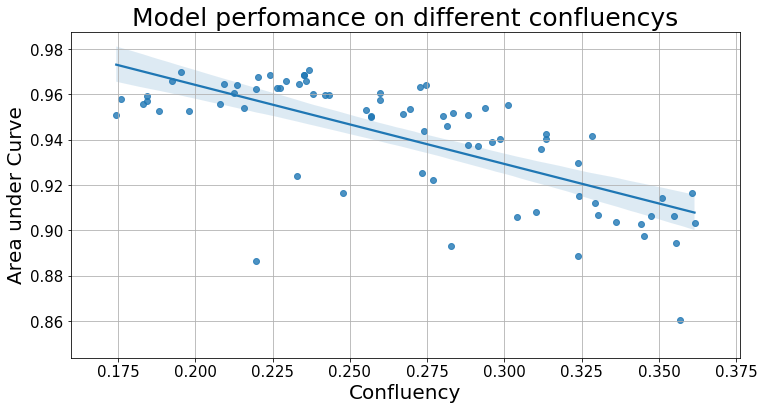

In [48]:
sns.regplot(confluencys, aucs)
plt.title("Model perfomance on different confluencys", fontsize=25)
plt.xlabel("Confluency", fontsize=20)
plt.ylabel("Area under Curve", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

# Genralization on unseen cell types

To be able to this evaluation we need one model trained on all cell types except the one we want to test how well we generalize on.

In [70]:
MODEL_DIR = Path(r"D:\Nabil_object_detection\models")

MODEL_PATHS = pd.DataFrame({
    "microscope": ["bf", "lf", "bf", "lf"],
    "model": ["rcnn", "rcnn", "ssd", "ssd"],
    "training": ["3t3", "3t3", "3t3", "3t3"],
    "path": [
        MODEL_DIR.joinpath(r"graph_generalization_trained_on_3t3\faster_rcnn_resnet50_10x"),
        MODEL_DIR.joinpath(r"graph_generalization_trained_on_3t3\faster_rcnn_resnet50_z00"),
        MODEL_DIR.joinpath(r"graph_generalization_trained_on_3t3\ssd_resnet50_v1_fpn_10x_tiles0_bboxes40"),
        MODEL_DIR.joinpath(r"graph_generalization_trained_on_3t3\ssd_resnet50_v1_fpn_z00_tiles0_bboxes40")
    ]
})

In [71]:
MODEL_PATHS.head()

,microscope,model,training,path
0,bf,rcnn,3t3,D:\Nabil_object_detection\models\graph_general...
1,lf,rcnn,3t3,D:\Nabil_object_detection\models\graph_general...
2,bf,ssd,3t3,D:\Nabil_object_detection\models\graph_general...
3,lf,ssd,3t3,D:\Nabil_object_detection\models\graph_general...


In [41]:
# Directory must contain one folder for every cell type.
CELL_TYPE_DIR = Path(r"D:\Nabil_object_detection\cell_type")

# Print folder structure.
for cell_type in CELL_TYPE_DIR.glob("*/"):
    print(f"\nCell type: {cell_type.name} \t ({cell_type})")
    for data in cell_type.glob("*.tfrecord"):
        print(f"\t{data.name}")


Cell type: 3t3 	 (D:\Nabil_object_detection\cell_type\3t3)
	10x.tfrecord
	z00.tfrecord

Cell type: nrk 	 (D:\Nabil_object_detection\cell_type\nrk)
	10x.tfrecord
	z00.tfrecord


In [76]:
# TODO